# HW3 - Stock Movement Prediction

作業檔案：
- hw3.ipynb

資料：
https://www.sharecast.com/index/SP_500/prices/download

- train.csv: S&P 500 訓練資料(2009-2017)
- test.csv: S&P 500 測試資料(2018)


In [1]:
# Read data
import math
import matplotlib.pyplot   as plt
import pandas              as pd
import numpy               as np
import seaborn             as sns; sns.set()
import torch
import torch.nn.functional as F
from sklearn               import svm
from sklearn.svm           import SVC


train_data_path = 'train.csv'
test_data_path = 'test.csv'

train_df = pd.read_csv(train_data_path)
#train_df where store train data
test_df = pd.read_csv(test_data_path)
#test_df where store train data

print(train_df.shape)
print(train_df.head())
print(test_df.shape)
print(test_df.head())

(2264, 6)
          Date  Open Price  Close Price  High Price  Low Price      Volume
0  02-Jan-2009      902.99       931.80      934.73     899.35  4048270080
1  05-Jan-2009      929.17       927.45      936.63     919.53  5413910016
2  06-Jan-2009      931.17       934.70      943.85     927.28  5392620032
3  07-Jan-2009      927.45       906.65      927.45     902.37  4704940032
4  08-Jan-2009      905.73       909.73      910.00     896.81  4991549952
(252, 6)
          Date  Open Price  Close Price  High Price  Low Price      Volume
0  02-Jan-2018     2683.73      2695.81     2695.89    2682.36  1846463232
1  03-Jan-2018     2697.85      2713.06     2714.37    2697.77  2090595328
2  04-Jan-2018     2719.31      2723.99     2729.29    2719.07  2100767744
3  05-Jan-2018     2731.33      2743.15     2743.45    2727.92  1918869120
4  08-Jan-2018     2742.67      2747.71     2748.51    2737.60  1894823936


In [2]:
# Drop unnecessary columns

drop_col_names = ['Date'] # !--- or you can modify it to drop the columns you don't want ---!
#take away Date

train_df.drop(columns=drop_col_names, inplace=True)
test_df.drop(columns=drop_col_names, inplace=True)


print(train_df.shape)
print(train_df.head())
print(test_df.shape)
print(test_df.head())

(2264, 5)
   Open Price  Close Price  High Price  Low Price      Volume
0      902.99       931.80      934.73     899.35  4048270080
1      929.17       927.45      936.63     919.53  5413910016
2      931.17       934.70      943.85     927.28  5392620032
3      927.45       906.65      927.45     902.37  4704940032
4      905.73       909.73      910.00     896.81  4991549952
(252, 5)
   Open Price  Close Price  High Price  Low Price      Volume
0     2683.73      2695.81     2695.89    2682.36  1846463232
1     2697.85      2713.06     2714.37    2697.77  2090595328
2     2719.31      2723.99     2729.29    2719.07  2100767744
3     2731.33      2743.15     2743.45    2727.92  1918869120
4     2742.67      2747.71     2748.51    2737.60  1894823936


In [3]:
# Add the column `Tomorrow Movement` by comparing the `Close Price` with the previous days as the training target

train_df['Tomorrow Movement'] = np.where(train_df['Close Price'].diff() >= 0, 1, 0)
test_df['Tomorrow Movement'] = np.where(test_df['Close Price'].diff() >= 0, 1, 0)


train_df['Tomorrow Movement'] = train_df['Tomorrow Movement'].shift(-1)
test_df['Tomorrow Movement'] = test_df['Tomorrow Movement'].shift(-1)

print(train_df.head())
print(train_df.tail())

   Open Price  Close Price  High Price  Low Price      Volume  \
0      902.99       931.80      934.73     899.35  4048270080   
1      929.17       927.45      936.63     919.53  5413910016   
2      931.17       934.70      943.85     927.28  5392620032   
3      927.45       906.65      927.45     902.37  4704940032   
4      905.73       909.73      910.00     896.81  4991549952   

   Tomorrow Movement  
0                0.0  
1                1.0  
2                0.0  
3                1.0  
4                0.0  
      Open Price  Close Price  High Price  Low Price      Volume  \
2259     2684.22      2683.34     2685.35    2678.13  1383888512   
2260     2679.09      2680.50     2682.74    2677.96  1103808384   
2261     2682.10      2682.62     2685.64    2678.91  1149108352   
2262     2686.10      2687.54     2687.66    2682.69  1126089856   
2263     2689.15      2673.61     2692.12    2673.61  1332374016   

      Tomorrow Movement  
2259                0.0  
2260      

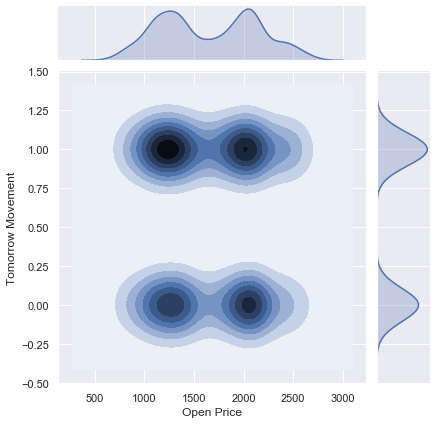

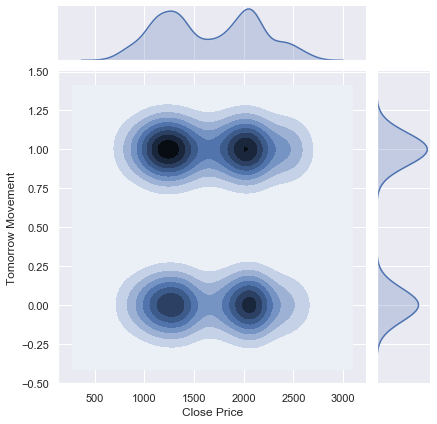

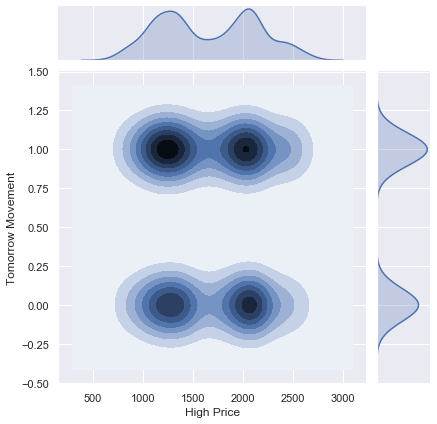

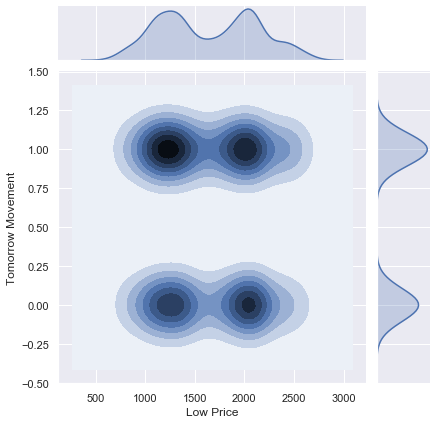

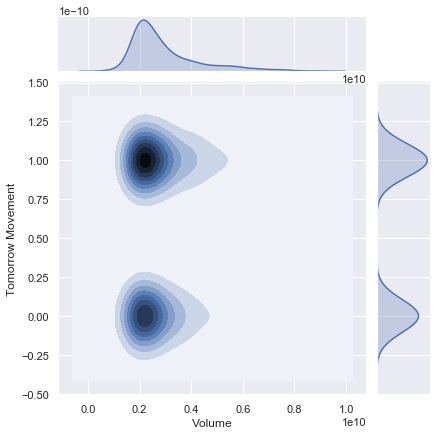

In [4]:
# !--- You can add your own data preprocessing here ---!
#At first ,I have no idea aabout what I should to do
for feature in train_df.columns:
    if feature == 'Tomorrow Movement':
        continue
    sns.jointplot(x=feature, y='Tomorrow Movement', data = train_df, kind='kde')
    plt.show

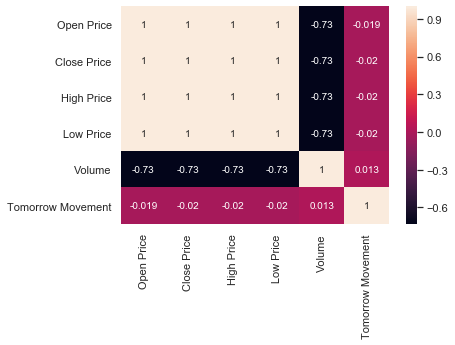

In [5]:
sns.heatmap(train_df.corr(), annot=True)

In [6]:
# Drop rows with NaN values

train_df = train_df.dropna()
test_df = test_df.dropna()

print(train_df.shape)
print(train_df)
print(test_df.shape)
print(test_df)

(2263, 6)
      Open Price  Close Price  High Price  Low Price      Volume  \
0         902.99       931.80      934.73     899.35  4048270080   
1         929.17       927.45      936.63     919.53  5413910016   
2         931.17       934.70      943.85     927.28  5392620032   
3         927.45       906.65      927.45     902.37  4704940032   
4         905.73       909.73      910.00     896.81  4991549952   
5         909.91       890.35      911.93     888.31  4716499968   
6         890.40       870.26      890.40     864.32  4725049856   
7         869.79       871.79      877.02     862.02  5017469952   
8         867.28       842.62      867.28     836.93  5407880192   
9         841.99       843.74      851.59     817.04  7807350272   
10        844.45       850.12      858.13     830.66  6786039808   
11        849.64       805.22      849.64     804.47  6375229952   
12        806.77       840.24      841.72     804.30  6467829760   
13        839.74       827.50      839

In [7]:
# Divide x and y data

train_x_df = train_df.drop(columns = ['Tomorrow Movement'])
train_y_df = train_df['Tomorrow Movement']

test_x_df  = test_df.drop(columns = ['Tomorrow Movement'])
test_y_df  = test_df['Tomorrow Movement']

#input new features

train_x_df['Open Price**32'] = train_x_df['Open Price']**32
test_x_df['Open Price**32']  = test_x_df['Open Price']**32

train_x_df['Open Price**32'] = train_x_df['Open Price']**32
test_x_df['Open Price**32']  = test_x_df['Open Price']**32

train_x_df['change squre'] = (train_x_df['Open Price']-train_x_df['Close Price'])*(train_x_df['High Price']-train_x_df['Low Price'])
test_x_df['change squre']  = (test_x_df['Open Price']-test_x_df['Close Price'])*(test_x_df['High Price']-test_x_df['Low Price'])



print(train_x_df.shape)
print(train_x_df.head())
print(train_y_df.shape)
print(train_y_df.head())
print('-----')
print(test_x_df.shape)
print(test_x_df.head())
print(test_y_df.shape)
print(test_y_df.head())



(2263, 7)
   Open Price  Close Price  High Price  Low Price      Volume  Open Price**32  \
0      902.99       931.80      934.73     899.35  4048270080    3.818160e+94   
1      929.17       927.45      936.63     919.53  5413910016    9.528965e+94   
2      931.17       934.70      943.85     927.28  5392620032    1.020768e+95   
3      927.45       906.65      927.45     902.37  4704940032    8.980410e+94   
4      905.73       909.73      910.00     896.81  4991549952    4.206880e+94   

   change squre  
0    -1019.2978  
1       29.4120  
2      -58.4921  
3      521.6640  
4      -52.7600  
(2263,)
0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
Name: Tomorrow Movement, dtype: float64
-----
(251, 7)
   Open Price  Close Price  High Price  Low Price      Volume  Open Price**32  \
0     2683.73      2695.81     2695.89    2682.36  1846463232   5.243754e+109   
1     2697.85      2713.06     2714.37    2697.77  2090595328   6.202540e+109   
2     2719.31      2723.99     2729.29    27

In [8]:
# Normalize data

# !--- Modify here if you want ---!


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_x_df)

normalized_train_x_df = scaler.transform(train_x_df)
normalized_train_x_df = np.transpose(normalized_train_x_df)


normalized_train_x_df = pd.DataFrame({
        'Open Price': normalized_train_x_df[0],
       'Close Price': normalized_train_x_df[1],
        'High Price': normalized_train_x_df[2],
         'Low Price': normalized_train_x_df[3],
            'Volume': normalized_train_x_df[4],
    'Open Price**32': normalized_train_x_df[5],
      'change squre': normalized_train_x_df[6],
})

normalized_test_x_df = scaler.transform(test_x_df)
normalized_test_x_df = np.transpose(normalized_test_x_df)

normalized_test_x_df = pd.DataFrame({
        'Open Price': normalized_test_x_df[0],
       'Close Price': normalized_test_x_df[1],
        'High Price': normalized_test_x_df[2],
         'Low Price': normalized_test_x_df[3],
            'Volume': normalized_test_x_df[4],
    'Open Price**32': normalized_test_x_df[5],
      'change squre': normalized_test_x_df[6],
})

print(normalized_train_x_df.shape)
print(normalized_train_x_df.head())
print(train_y_df.shape)
print(train_y_df.head())
print('-----')
print(normalized_test_x_df.shape)
print(normalized_test_x_df.head())
print(test_y_df.shape)
print(test_y_df.head())


(2263, 7)
   Open Price  Close Price  High Price  Low Price    Volume  Open Price**32  \
0   -1.552572    -1.494607   -1.505683  -1.541181  0.813175       -0.176864   
1   -1.498571    -1.503581   -1.501760  -1.499581  1.823826       -0.176864   
2   -1.494446    -1.488625   -1.486853  -1.483605  1.808070       -0.176864   
3   -1.502119    -1.546489   -1.520714  -1.534956  1.299148       -0.176864   
4   -1.546921    -1.540136   -1.556744  -1.546417  1.511255       -0.176864   

   change squre  
0     -2.013808  
1      0.039288  
2     -0.132805  
3      1.002987  
4     -0.121583  
(2263,)
0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
Name: Tomorrow Movement, dtype: float64
-----
(251, 7)
   Open Price  Close Price  High Price  Low Price    Volume  Open Price**32  \
0    2.120527     2.144366    2.130621   2.134397 -0.816287       11.434453   
1    2.149652     2.179951    2.168777   2.166163 -0.635616       13.557507   
2    2.193917     2.202498    2.199583   2.210072 -0.628087   

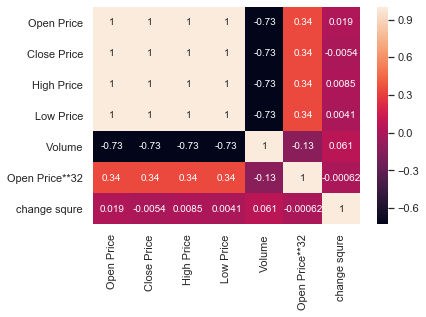

In [9]:
sns.heatmap(normalized_train_x_df.corr(), annot=True)

# Logistic Regression

In [10]:
# Train & Predict using Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics      import accuracy_score

lr_model = LogisticRegression()  # !--- Initialize the model here ---!
lr_model.fit(normalized_train_x_df,train_y_df) # !-- Fill the training data here --!

train_pred = lr_model.predict(normalized_train_x_df)
print ("Training acc: %.5f" % accuracy_score(train_y_df , train_pred))
test_pred = lr_model.predict(normalized_test_x_df)
print ("Testing acc: %.5f"  % accuracy_score(test_y_df  , test_pred))
 

Training acc: 0.54795
Testing acc: 0.54183


c:\users\hong jia cheng\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [11]:
# Print precision, recall, fbeta-score and confusion matrix

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

print('precision, recall, fbeta-score:')
print(precision_recall_fscore_support(test_y_df, test_pred, average='weighted'))
print('\nconfusion matrix(tn, fp, fn, tp):')
tn, fp, fn, tp = confusion_matrix(test_y_df, test_pred).ravel()
print((tn, fp, fn, tp))

precision, recall, fbeta-score:
(0.5400392731070023, 0.5418326693227091, 0.5398950453691841, None)

confusion matrix(tn, fp, fn, tp):
(56, 63, 52, 80)


# SVM

In [12]:
# Train & Predict with SVC


svc_model = SVC(gamma='scale') # !--- Initialize the model here ---!
#choose a model & input
svc_model.fit(normalized_train_x_df,train_y_df) # !-- Fill the training data here --!
#training data

train_pred = svc_model.predict(normalized_train_x_df)
print ("Training acc: %.5f" % accuracy_score(train_y_df, train_pred))
test_pred = svc_model.predict(normalized_test_x_df)
print ("Testing acc: %.5f"  % accuracy_score(test_y_df, test_pred))

Training acc: 0.55369
Testing acc: 0.50996


In [13]:
print('training accuracy:')
# !-- Predict training target & print the training accuracy here --!
svc_training_acc = np.mean(svc_model.predict(normalized_train_x_df) == train_y_df) 
#using model to predict y & compare with y ,where produce 0 (fail)/1(right) ,then mean them
print(svc_training_acc)

print('\ntesting accuracy:')
 #!-- Predict testing target & print the testing accuracy here --!
svc_predict_test_result = svc_model.predict(normalized_test_x_df)
svc_testing_acc = np.mean(svc_predict_test_result == test_y_df)
print(svc_testing_acc)

print('\npredicted testing labels:')
print(svc_predict_test_result)

training accuracy:
0.5536897923110915

testing accuracy:
0.5099601593625498

predicted testing labels:
[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.]


In [14]:
print(type(svc_predict_test_result))


<class 'numpy.ndarray'>


In [15]:
# Print precision, recall, fbeta-score and confusion matrix

print('precision, recall, fbeta-score:')
print(precision_recall_fscore_support(test_y_df, svc_predict_test_result, average='weighted'))
print('\nconfusion matrix(tn, fp, fn, tp):')
tn, fp, fn, tp = confusion_matrix(test_y_df, svc_predict_test_result).ravel()
print((tn, fp, fn, tp))

precision, recall, fbeta-score:
(0.48301723979657407, 0.5099601593625498, 0.43351332016727734, None)

confusion matrix(tn, fp, fn, tp):
(15, 104, 19, 113)


In [16]:
# Define NN output groundtruth
falling_prob = pd.DataFrame(data=np.where(train_y_df == 0, 1, 0)[:])
train_y_dff = pd.DataFrame(data=np.where(train_y_df == 0, 0, 1)[:])
train_y_dff = pd.concat( [ falling_prob, train_y_df ], axis=1, ignore_index=True )

falling_prob = pd.DataFrame(data=np.where(test_y_df == 0, 1, 0)[:])
test_y_dff = pd.DataFrame(data=np.where(test_y_df == 0, 0, 1)[:])
test_y_dff = pd.concat( [ falling_prob, test_y_df ], axis=1, ignore_index=True )


print(train_y_dff.shape)
print(train_y_dff.head())
print(test_y_dff.shape)
print(test_y_dff.head())

(2263, 2)
   0    1
0  1  0.0
1  0  1.0
2  1  0.0
3  0  1.0
4  1  0.0
(251, 2)
   0    1
0  0  1.0
1  0  1.0
2  0  1.0
3  0  1.0
4  0  1.0


 # Neural Network

In [59]:
from keras import models, layers, optimizers, regularizers
hidden_units = 12     # how many neurons in the hidden layer
activation = 'relu'   # activation function for hidden layer
l2 = 0.01             # regularization - how much we penalize large parameter values
learning_rate = 0.01  # how big our steps are in gradient descent
epochs = 20            # how many epochs to train for
batch_size = 4       # how many samples to use for each gradient descent update

In [60]:
# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add(layers.Dense(input_dim=7,
                       units=hidden_units, 
                       activation=activation))

# add the output layer
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

Epoch 1/10
2263/2263 [==============================] - 1s 519us/step - loss: 0.7056 - acc: 0.5091
Epoch 2/10
2263/2263 [==============================] - 1s 272us/step - loss: 0.6923 - acc: 0.5373
Epoch 3/10
2263/2263 [==============================] - 1s 270us/step - loss: 0.6933 - acc: 0.5400
Epoch 4/10
2263/2263 [==============================] - 1s 277us/step - loss: 0.6908 - acc: 0.5347
Epoch 5/10
2263/2263 [==============================] - 1s 280us/step - loss: 0.6900 - acc: 0.5378
Epoch 6/10
2263/2263 [==============================] - 1s 290us/step - loss: 0.6899 - acc: 0.5457
Epoch 7/10
2263/2263 [==============================] - 1s 282us/step - loss: 0.6896 - acc: 0.5449
Epoch 8/10
2263/2263 [==============================] - 1s 288us/step - loss: 0.6903 - acc: 0.5462
Epoch 9/10
2263/2263 [==============================] - 1s 288us/step - loss: 0.6895 - acc: 0.5444
Epoch 10/10
251/251 [==============================] - 0s 24us/step
Training accuracy: 0.5475033142373881
Tes

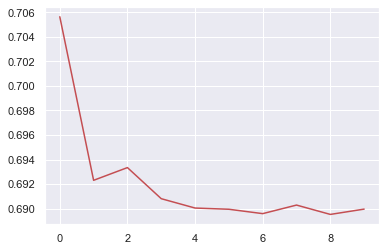

In [61]:
# train the parameters
history = model.fit(normalized_train_x_df, train_y_df, epochs=10, batch_size=batch_size)

result_test = model.predict_classes(normalized_test_x_df)

result_test = np.reshape(result_test,(result_test.size,))
# evaluate accuracy
train_acc = model.evaluate(normalized_train_x_df, train_y_df, batch_size=32)[1]



test_acc = model.evaluate(normalized_test_x_df, test_y_df, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

#transfer data into float from ,in order to fit answer 
result_test = pd.DataFrame(data=np.where(result_test == 0, 0.0,1.0)[:])


losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()


In [62]:
print(result_test)
print(result_test.shape)
print(test_y_df)
print(test_y_df.shape)

       0
0    1.0
1    1.0
2    1.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
10   0.0
11   0.0
12   0.0
13   0.0
14   0.0
15   0.0
16   0.0
17   0.0
18   0.0
19   0.0
20   0.0
21   0.0
22   0.0
23   1.0
24   1.0
25   1.0
26   1.0
27   1.0
28   1.0
29   1.0
..   ...
221  1.0
222  1.0
223  1.0
224  1.0
225  1.0
226  1.0
227  1.0
228  1.0
229  1.0
230  0.0
231  1.0
232  0.0
233  1.0
234  1.0
235  1.0
236  1.0
237  1.0
238  1.0
239  1.0
240  1.0
241  1.0
242  1.0
243  1.0
244  1.0
245  1.0
246  1.0
247  1.0
248  0.0
249  1.0
250  1.0

[251 rows x 1 columns]
(251, 1)
0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
5      0.0
6      1.0
7      1.0
8      0.0
9      1.0
10     0.0
11     1.0
12     1.0
13     1.0
14     0.0
15     1.0
16     1.0
17     0.0
18     0.0
19     1.0
20     0.0
21     0.0
22     0.0
23     1.0
24     0.0
25     0.0
26     1.0
27     1.0
28     1.0
29     1.0
      ... 
221    1.0
222    0.0
223    0.0
224    1.0
225    0.0
226    1.0
22

In [21]:
# Print precision, recall, fbeta-score and confusion matrix

print('\nprecision, recall, fbeta-score:')
print(precision_recall_fscore_support(test_y_df, result_test, average='weighted'))
print('\nconfusion matrix(tn, fp, fn, tp):')
tn, fp, fn, tp = confusion_matrix(test_y_df, result_test).ravel()
print((tn, fp, fn, tp))


precision, recall, fbeta-score:
(0.5321903873866237, 0.50199203187251, 0.4492772807622788, None)

confusion matrix(tn, fp, fn, tp):
(99, 20, 105, 27)


In [22]:
# Define NN output groundtruth

#falling_prob = pd.DataFrame(data=np.where(train_y_df == 0, 1, 0)[:])
#train_y_df = pd.DataFrame(data=np.where(train_y_df == 0, 0, 1)[:])
#train_y_df = pd.concat( [ falling_prob, train_y_df ], axis=1, ignore_index=True )

#falling_prob = pd.DataFrame(data=np.where(test_y_df == 0, 1, 0)[:])
#test_y_df = pd.DataFrame(data=np.where(test_y_df == 0, 0, 1)[:])
#test_y_df = pd.concat( [ falling_prob, test_y_df ], axis=1, ignore_index=True )

#print(train_y_df.shape)
#print(train_y_df.head())

# Define NN structure

import torch
import torch.nn.functional as F

 !--- You can modify the NN structure here ---!
class M_NN(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(M_NN, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        h = self.linear1(x)
        acti_out = F.relu(h)
        y_pred = self.linear2(h)
        return y_pred


# N = batch size, D_in = input size, H = hidden size, D_out = output size
N, D_in, H, D_out = 600, 6, 100, 2  # !--- You can modify here ---!

model = M_NN(D_in, H, D_out)
criterion = torch.nn.BCEWithLogitsLoss(reduction='sum') # !--- You can modify here ---!
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # !--- You can modify here ---!


# Train NN
# !--- You can modify here ---!
print()

for t in range(1000):
    for batch_num in range(0, len(normalized_train_x_df), N): 
        
        y_pred = model(torch.FloatTensor(normalized_train_x_df[:batch_num+N].values.tolist()))   # !-- Fill the training batch data here --!
        target = torch.Float(normalized_test_x_df[:batch_num+N].values)
        loss = criterion(torch.FloatTensor(normalized_test_x_df[:batch_num+N].values.tolist())) # !-- Fill the prediction & groundtruth here to calculate loss --!
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (t%100 == 0):
        print('epoch:%d - loss:%.10f' % (t, loss.item()))

# Discussion

### Runable test
    #### At the first, I fill up the necessary to print out out accuracy & some SVM model ,making the project runnable.By the way ,  because I can't handle  'class' very  well ,  I use the code in class to replace it & change some data form , fitting   precision_recall_fscore_support's data need .

    the first output in LR model is very poor ,so I guess some feature I have to produce from origin data.After analyzing the data with joint plot ,they seems to have no relation with movementin LR training , I think Open price will dominat decision ,so I use  Open Price\**32 into as new feature  to learn ,outcome is here .In this process , I think it is lucky condition ,because acc will decrease when parameter is a little different.

### LR model
    #### Training acc: 0.54750
    #### Testing acc: 0.57371

    So I turn back to data_preprcessing,puting 'change squre' as new feasures,making Logistic Regression more reasonable,having similar accurracy.
#### Training acc: 0.54795
#### Testing acc: 0.54183

### SVM
    the output in SVM model is very worse,acc for testing only roughly 0.5 , throw the coin into air to predict is 0.5,too. I think this model is not good to predict movement 

#### training accuracy:0.5536897923110915
#### Testing acc: 0.5099601593625498

### Neural Network
    I can modify more parameter here ,then hidden_units & epochs & batch_size are what I focus on.

    hidden_units = 10 
    epochs = 10          
    batch_size = 2

    Training accuracy: 0.5475033142373881
    Testing accuracy: 0.5219123509538126

### epochs 
    change epochs to 4
    Training accuracy: 0.5475033142373881
    Testing accuracy: 0.525896415529973
    no obvious　change　so return origin value ,epochs = 10 
    I try some numbers as parameter ,but outcome is bad 

### hidden_units
    change hidden_units to 12 
    Training accuracy: 0.5475033142373881
    Testing accuracy: 0.525896415529973
### batch_size
    change batch_size to 4
    Training accuracy: 0.5550154662479935
    Testing accuracy: 0.5258964146988325
#### OTHER TRY    
    hidden_units = 12    
    epochs = 20           
    batch_size = 4   
    
    Training accuracy: 0.5475033142373881
    Testing accuracy: 0.5378486059338923
    
### Summary 
    After some adjusting , LR is the best predictor here ; outlier effect SVM easily ,so it have worst prediction;NN need more data to complete　data base , small database will lead to bad accuracy easily.